In [ ]:
# Imports
import pandas as pd
import numpy as np
import datetime
from datetime import time as dtime
from datetime import timedelta
from datetime import date
import matplotlib as plt
from itertools import product
import openpyxl

# pd.set_option('display.max_rows', None)     # show all rows
# pd.set_option('display.max_columns', None)  # show all columns
# pd.set_option('display.width', None)        # don't wrap lines
# pd.set_option('display.max_colwidth', None)



# importing historical data for backtest
def get1minBars(csvName):
    
    priceData1minBars_df = pd.read_csv(csvName, usecols=['date', 'open', 'high', 'low', 'close', 'volume'])
    
    # Parse datetime column and divide in 2 columns
    # SPY_Data['datetime'] = pd.to_datetime(SPY_Data['date'].str.strip(), format='%Y%m%d %H:%M:%S')
    priceData1minBars_df.rename(columns={
        'date': 'datetime'
    }, inplace=True)
    
    priceData1minBars_df['datetime'] = pd.to_datetime(priceData1minBars_df['datetime'])
    
    priceData1minBars_df['Date'] = priceData1minBars_df['datetime'].dt.date
    priceData1minBars_df['Time'] = priceData1minBars_df['datetime'].dt.time
    
    # sorting the data by the time column to make sure it is consistent
    priceData1minBars_df.sort_values('datetime', inplace=True)
    
    # Drop original 'date' column
    # SPY_Data.drop(columns=['date'], inplace=True)
    
    # Filter for regular trading hours using datetime column
    # priceData1minBars_df = priceData1minBars_df[priceData1minBars_df['datetime'].dt.time >= pd.to_datetime("09:30").time()]
    # priceData1minBars_df = priceData1minBars_df[priceData1minBars_df['datetime'].dt.time <= pd.to_datetime("16:00").time()]
    
    # Making sure the order of the columns stays the same 
    priceData1minBars_df = priceData1minBars_df[['Date', 'Time', 'open', 'high', 'low', 'close', 'volume']]
    
    return priceData1minBars_df
    
    
ES_Data = get1minBars('ES_1min_master.csv')
ES_Data = ES_Data.drop_duplicates()
# QQQ_Data = QQQ_Data[472980:483000]
# ES_Data = ES_Data[:int(len(ES_Data)/2)]

ES_Data_full = ES_Data.copy()

# -----------------------------------
from datetime import date

start = date(2024, 11, 1)
end   = date(2024, 11, 30)

ES_Data_Nov2024 = ES_Data[
    (ES_Data['Date'] >= start) &
    (ES_Data['Date'] <= end)
].copy()
# -----------------------------------

date_str = '2025-04-30'
day = pd.to_datetime(date_str).date()
ES_Data = ES_Data_full[ES_Data_full['Date'] == day].copy()




ES_Data
# ES_Data_Nov2024



import pandas as pd
import numpy as np

def add_session_id(df: pd.DataFrame, start_hour: int = 23) -> pd.DataFrame:
    """
    Adds:
      - session_date: the trading session label date (rolls at start_hour)
      - session_ID  : 1..N integer increasing over time

    Assumes df has either:
      - 'datetime' column, OR
      - 'Date' and 'Time' columns (Date as date-like, Time as time-like or string)
    """
    out = df.copy()

    # Ensure datetime exists
    if "datetime" not in out.columns:
        out["datetime"] = pd.to_datetime(
            out["Date"].astype(str) + " " + out["Time"].astype(str),
            errors="coerce"
        )

    out = out.sort_values("datetime").reset_index(drop=True)

    # Base calendar date from datetime
    base_date = out["datetime"].dt.date

    # Roll session date at start_hour (23:00)
    roll = out["datetime"].dt.hour >= start_hour
    out["session_date"] = pd.to_datetime(base_date) + pd.to_timedelta(roll.astype(int), unit="D")
    out["session_date"] = out["session_date"].dt.date  # keep as date (optional)

    # Monotonic integer id (1..N) in time order
    # Use factorize on the ordered unique session_date sequence
    out["session_ID"] = pd.factorize(out["session_date"], sort=True)[0] + 1

    return out

# usage
ES_Data_full = add_session_id(ES_Data_full, start_hour=23)
ES_Data_full




import numpy as np
import pandas as pd
from datetime import time as dtime

# ------- Minimal ADX helper (used only if DIp14/60, DIn14/60, ADX14/60 not already present) -------
def _compute_adx_block(df, n=14, per_session=True):
    out = df.copy()
    if per_session:
        prev_high = out.groupby('Date')['high'].shift(1)
        prev_low  = out.groupby('Date')['low'].shift(1)
        prev_close= out.groupby('Date')['close'].shift(1)
    else:
        prev_high = out['high'].shift(1)
        prev_low  = out['low'].shift(1)
        prev_close= out['close'].shift(1)

    up_move   = out['high'] - prev_high
    down_move = prev_low - out['low']
    plus_dm   = np.where((up_move > 0) & (up_move > down_move), up_move, 0.0)
    minus_dm  = np.where((down_move > 0) & (down_move > up_move), down_move, 0.0)
    plus_dm   = pd.Series(plus_dm, index=out.index)
    minus_dm  = pd.Series(minus_dm, index=out.index)

    tr1 = (out['high'] - out['low']).abs()
    tr2 = (out['high'] - prev_close).abs()
    tr3 = (out['low'] - prev_close).abs()
    tr = np.maximum(tr1, np.maximum(tr2, tr3)).fillna(tr1)

    def _smooth(s, n_):
        return s.ewm(alpha=1/n_, adjust=False).mean()

    if per_session:
        tr_n      = tr.groupby(out['Date']).transform(lambda s: _smooth(s, n))
        plus_dm_n = plus_dm.groupby(out['Date']).transform(lambda s: _smooth(s, n))
        minus_dm_n= minus_dm.groupby(out['Date']).transform(lambda s: _smooth(s, n))
    else:
        tr_n      = _smooth(tr, n)
        plus_dm_n = _smooth(plus_dm, n)
        minus_dm_n= _smooth(minus_dm, n)

    eps = 1e-12
    dip = 100.0 * (plus_dm_n / (tr_n + eps))
    din = 100.0 * (minus_dm_n / (tr_n + eps))
    dx  = 100.0 * (np.abs(dip - din) / (dip + din + eps))
    adx = (dx.groupby(out['Date']).transform(lambda s: _smooth(s, n))
           if per_session else _smooth(dx, n))

    return dip, din, adx

# ------- ATR helper (Wilder), per session if desired -------
def _wilder_atr(df, n, per_session=True):
    if per_session:
        prev_close = df.groupby('Date')['close'].shift(1)
    else:
        prev_close = df['close'].shift(1)
    tr1 = (df['high'] - df['low']).abs()
    tr2 = (df['high'] - prev_close).abs()
    tr3 = (df['low'] - df['close'].shift(1)).abs()
    tr = np.maximum(tr1, np.maximum(tr2, tr3)).fillna(tr1)
    smooth = tr.groupby(df['Date']).transform(lambda s: s.ewm(alpha=1/n, adjust=False).mean()) \
             if per_session else tr.ewm(alpha=1/n, adjust=False).mean()
    return smooth

# ------- Time-in-window helper (handles str, datetime.time, or Timestamp) -------
def _in_windows(t, windows):
    if isinstance(t, pd.Timestamp):
        tt = t.time()
    elif isinstance(t, str):
        # parse fast HH:MM:SS or HH:MM
        parts = [int(x) for x in t.split(':')]
        while len(parts) < 3: parts.append(0)
        tt = dtime(parts[0], parts[1], parts[2])
    else:
        tt = t  # assume datetime.time
    for start, end in windows:
        if start <= tt <= end:
            return True
    return False

def classify_market_regime(
    df,
    atr_per_session=False,
    params=None,
    time_windows=None,
):
    """
    Adds regime labels & filters.

    Inputs:
      df: DataFrame with columns ['Date','Time','open','high','low','close','volume']
          and ideally DIp14/DIn14/ADX14 & DIp60/DIn60/ADX60 (will compute if missing).
      atr_per_session: reset ATR/ADX within each Date session if True.

    params (defaults below):
      {
        'adx14_chop': 20,
        'adx60_trend': 18,
        'vol_ratio_expand': 1.20,   # ATR5/ATR60 >= expand → expansion
        'vol_ratio_chop':   0.90,   # ATR5/ATR60 <= chop   → compression
        'adx14_rise_lookback': 5,   # rising ADX14 over N bars
        'min_range_mult_exhaust': 2.0,  # optional: mark exhaustion bars (not used to filter, but computed)
      }

    time_windows:
      list of (start_time, end_time) tuples; times as datetime.time.
      Defaults to RTH focus: [(09:35, 11:30), (13:30, 15:30)] Eastern-like.
    """
    if params is None:
        params = dict(
            adx14_chop=20,
            adx60_trend=18,
            vol_ratio_expand=1.20,
            vol_ratio_chop=0.90,
            adx14_rise_lookback=5,
            min_range_mult_exhaust=2.0,
        )

    if time_windows is None:
        time_windows = [(dtime(9,35), dtime(11,30)), (dtime(13,30), dtime(15,30))]

    out = df.copy()
    out[['open','high','low','close']] = out[['open','high','low','close']].astype(float)

    # --- Ensure ADX14/60 (+DI/-DI) exist (compute if missing) ---
    need_14 = not {'DIp14','DIn14','ADX14'}.issubset(out.columns)
    need_60 = not {'DIp60','DIn60','ADX60'}.issubset(out.columns)
    if need_14:
        dip14, din14, adx14 = _compute_adx_block(out, n=14, per_session=atr_per_session)
        out['DIp14'], out['DIn14'], out['ADX14'] = dip14, din14, adx14
    if need_60:
        dip60, din60, adx60 = _compute_adx_block(out, n=60, per_session=atr_per_session)
        out['DIp60'], out['DIn60'], out['ADX60'] = dip60, din60, adx60

    # --- ATRs & Volatility ratio ---
    out['ATR5']  = _wilder_atr(out, 5,  per_session=atr_per_session)
    out['ATR60'] = _wilder_atr(out, 60, per_session=atr_per_session)
    eps = 1e-12
    out['vol_ratio'] = (out['ATR5'] / (out['ATR60'] + eps)).clip(lower=0)

    # --- ADX14 rising metric ---
    look = int(params['adx14_rise_lookback'])
    out['ADX14_rise'] = out['ADX14'] - out['ADX14'].shift(look)

    # --- Optional: exhaustion bar marker (current range vs 20-bar avg) ---
    out['range'] = (out['high'] - out['low']).abs()
    out['avg_range20'] = out['range'].rolling(20).mean()
    out['is_exhaustion'] = out['range'] > (params['min_range_mult_exhaust'] * out['avg_range20'])

    # --- Regime rules ---
    chop = (out['ADX14'] <= params['adx14_chop']) & (out['vol_ratio'] <= params['vol_ratio_chop'])
    trend_up   = (out['ADX60'] >= params['adx60_trend']) & (out['DIp60'] > out['DIn60'])
    trend_down = (out['ADX60'] >= params['adx60_trend']) & (out['DIp60'] < out['DIn60'])
    expansion  = (out['vol_ratio'] >= params['vol_ratio_expand']) & (out['ADX14_rise'] > 0)

    # Priority: expansion > trend > chop > neutral
    regime = np.where(expansion, 'expansion',
              np.where(trend_up, 'trend_up',
              np.where(trend_down, 'trend_down',
              np.where(chop, 'chop', 'neutral'))))
    out['regime'] = regime

    # Side bias
    out['side_bias'] = np.where(out['regime']=='trend_up', 'long',
                         np.where(out['regime']=='trend_down', 'short', 'neutral'))

    # Time-of-day tradability
    out['in_window'] = [ _in_windows(t, time_windows) for t in out['Time'] ]
    # Tradable regimes (you can tweak)
    tradable_regimes = {'expansion', 'trend_up', 'trend_down'}
    # out['tradable'] = out['in_window'] & out['regime'].isin(tradable_regimes)
    out['tradable'] = out['regime'].isin(tradable_regimes)
    
    

    return out

regime_df = classify_market_regime(ES_Data_full)


sig_cols = ['regime','side_bias','tradable','in_window',
            'vol_ratio','ADX14','ADX60','DIp60','DIn60','DIp14','DIn14',
            'ADX14_rise','ATR5','ATR60']

regime_df[sig_cols] = regime_df.groupby('Date')[sig_cols].shift(1)
regime_df

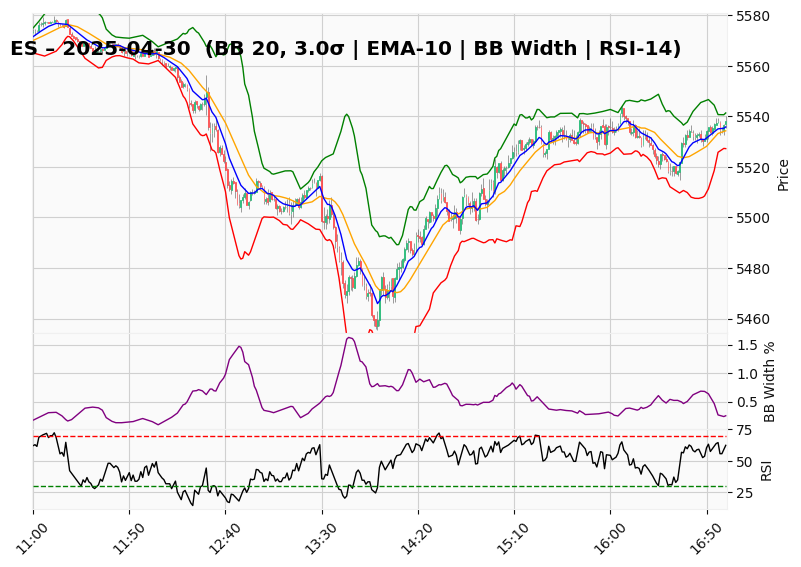

In [3]:
import pandas as pd
import numpy as np

def add_bollinger_es(df: pd.DataFrame,
                     length: int = 20,
                     mult: float = 2.0) -> pd.DataFrame:
    """
    Add Bollinger Bands on close:
      - bb_mid  : rolling mean
      - bb_up   : upper band
      - bb_dn   : lower band
      - bb_width: bb_up - bb_dn
      - bb_z    : (close - mid) / std
      - bb_spike_up   : True if high pierces upper band
      - bb_spike_down : True if low pierces lower band
    Assumes df has columns: Date, Time, open, high, low, close.
    """

    data = df.copy().reset_index(drop=True)

    # rolling mean and std on close
    rolling_mean = data["close"].rolling(length, min_periods=length).mean()
    rolling_std  = data["close"].rolling(length, min_periods=length).std(ddof=0)

    data["bb_mid"]   = rolling_mean
    data["bb_up"]    = rolling_mean + mult * rolling_std
    data["bb_dn"]    = rolling_mean - mult * rolling_std
    data["bb_width"] = data["bb_up"] - data["bb_dn"]
    data["bb_width_pct"] = (data["bb_up"] - data["bb_dn"]) / data["bb_mid"] * 100
    data["bb_z"]     = (data["close"] - data["bb_mid"]) / rolling_std

    # simple “spike” flags: price piercing bands
    data["bb_spike_up"]   = data["high"] > data["bb_up"]
    data["bb_spike_down"] = data["low"]  < data["bb_dn"]

    return data


import mplfinance as mpf


def add_rsi(df: pd.DataFrame, length: int = 14, price_col: str = "close", out_col: str = "rsi") -> pd.DataFrame:
    out = df.copy()
    px = pd.to_numeric(out[price_col], errors="coerce").astype(float)

    delta = px.diff()
    gain = delta.clip(lower=0.0)
    loss = (-delta).clip(lower=0.0)

    # Wilder smoothing via EMA(alpha=1/n)
    avg_gain = gain.ewm(alpha=1/length, adjust=False, min_periods=length).mean()
    avg_loss = loss.ewm(alpha=1/length, adjust=False, min_periods=length).mean()

    rs = avg_gain / avg_loss.replace(0, np.nan)
    out[out_col] = 100.0 - (100.0 / (1.0 + rs))

    return out



def plot_es_bollinger_day(ES_Data: pd.DataFrame,
                          date_str: str,
                          length: int = 20,
                          mult: float = 2.0,
                          rsi_len: int = 14,
                          t_start=None,
                          t_end=None):
    """
    Plot one ES day with:
      - Candlesticks
      - Bollinger Bands
      - EMA-10
      - BB Width (%)
      - RSI
    """

    day = pd.to_datetime(date_str).date()

    df = ES_Data[ES_Data["Date"] == day].copy()
    if df.empty:
        raise ValueError(f"No rows for {day} in ES_Data")

    # ---- Bollinger ----
    df = add_bollinger_es(df, length=length, mult=mult)

    # ---- RSI ----
    df = add_rsi(df, length=rsi_len, price_col="close", out_col="rsi")

    # ---- EMA-10 ----
    df["ema10"] = df["close"].ewm(span=10, adjust=False).mean()

    # ---- datetime index ----
    df["ts"] = pd.to_datetime(df["Date"].astype(str) + " " + df["Time"].astype(str))
    df = df.drop_duplicates(subset="ts")
    df = df.sort_values("ts").set_index("ts")
    df.index = pd.DatetimeIndex(df.index)

    # ---- optional intraday window ----
    if t_start is not None and t_end is not None:
        t0 = pd.to_datetime(t_start).time()
        t1 = pd.to_datetime(t_end).time()
        mask = (df.index.time >= t0) & (df.index.time <= t1)
        df = df.loc[mask]

    if df.empty:
        raise ValueError("No data in the selected intraday window.")

    # ---- overlay plots ----
    apds = [
        # ===== Main price panel =====
        mpf.make_addplot(df["bb_mid"], color="orange", width=1, panel=0),
        mpf.make_addplot(df["bb_up"],  color="green",  width=1, panel=0),
        mpf.make_addplot(df["bb_dn"],  color="red",    width=1, panel=0),
        mpf.make_addplot(df["ema10"],  color="blue",   width=1, panel=0),

        # ===== BB Width panel =====
        mpf.make_addplot(df["bb_width_pct"],
                         color="purple",
                         width=1,
                         panel=1,
                         ylabel="BB Width %"),

        # ===== RSI panel =====
        mpf.make_addplot(df["rsi"],
                         color="black",
                         width=1,
                         panel=2,
                         ylabel="RSI"),

        # RSI reference levels
        mpf.make_addplot(pd.Series(70, index=df.index),
                         panel=2, color="red", linestyle="--", width=1),
        mpf.make_addplot(pd.Series(30, index=df.index),
                         panel=2, color="green", linestyle="--", width=1),
    ]

    mpf.plot(
        df[["open", "high", "low", "close"]],
        type="candle",
        style="yahoo",
        addplot=apds,
        title=f"ES – {day}  (BB {length}, {mult}σ | EMA-10 | BB Width | RSI-{rsi_len})",
        datetime_format="%H:%M",
        tight_layout=True,
        panel_ratios=(4, 1.2, 1)  # price / width / RSI
    )


# Example usage:

plot_es_bollinger_day(ES_Data_full,'2025-04-30', length=20, mult=3.0, rsi_len=14,
    t_start="11:00",t_end="17:00")
# )
# 
# plot_es_bollinger_day(ES_Data_full, '2025-04-30', length=20, mult=3.0,
#                       t_start="11:00", t_end="17:00")
                      # )


In [ ]:
import numpy as np
import pandas as pd


def _round_tick(x, tick=0.25, how="nearest"):
    """
    Round a price x to the nearest tick.
    how = 'nearest', 'up', 'down'
    """
    if pd.isna(x):
        return x

    r = x / tick

    if how == "nearest":
        return tick * round(r)

    elif how == "up":
        # avoid floating point drift (100.999999 → 101)
        return tick * np.ceil(r - 1e-12)

    elif how == "down":
        return tick * np.floor(r + 1e-12)

    else:
        raise ValueError("how must be 'nearest', 'up', or 'down'")



def summarize_trades(trades: pd.DataFrame, point_value: float = 50.0, avg_stop_points=None):
    """
    Summarize trade results:
      - total_pnl in dollars
      - max drawdown
      - MAR ratio (PnL / |DD|)
      - win rate
      - avg R if avg_stop_points was passed
    """

    if trades is None or trades.empty:
        return {
            "n_trades": 0,
            "total_pnl": 0.0,
            "max_dd": 0.0,
            "mar_ratio": 0.0,
            "win_rate": 0.0,
            "avg_R": 0.0,
        }

    t = trades.copy()
    t["pnl_dollars"] = t["pnl_points"] * point_value
    t["cum_pnl"] = t["pnl_dollars"].cumsum()
    t["cum_max"] = t["cum_pnl"].cummax()
    t["dd"] = t["cum_pnl"] - t["cum_max"]
    max_dd = t["dd"].min()

    wins = (t["pnl_points"] > 0).mean()
    total_pnl = t["pnl_dollars"].iloc[-1]

    if avg_stop_points is not None and avg_stop_points > 0:
        t["R"] = t["pnl_points"] / avg_stop_points
        avg_R = t["R"].mean()
    else:
        avg_R = 0.0

    if max_dd < 0:
        mar = total_pnl / abs(max_dd)
    else:
        mar = 0.0

    return {
        "n_trades": int(len(t)),
        "total_pnl": float(total_pnl),
        "max_dd": float(max_dd),
        "mar_ratio": float(mar),
        "win_rate": float(wins),
        "avg_R": float(avg_R),
    }









def add_daily_anchored_vwap(
    df: pd.DataFrame,
    price_source: str = "typical",   # "typical" or "close"
    date_col: str = "Date",
    out_col: str = "vwap_d",
) -> pd.DataFrame:
    out = df.copy()

    for c in ["high", "low", "close", "volume"]:
        out[c] = pd.to_numeric(out[c], errors="coerce")

    out[date_col] = pd.to_datetime(out[date_col]).dt.date

    # Ensure datetime for sorting if you have Date/Time columns
    if "datetime" not in out.columns and {"Date", "Time"}.issubset(out.columns):
        out["datetime"] = pd.to_datetime(out["Date"].astype(str) + " " + out["Time"].astype(str), errors="coerce")

    out = out.sort_values(["Date", "Time"] if "datetime" not in out.columns else ["datetime"]).reset_index(drop=True)

    if price_source == "typical":
        px = (out["high"] + out["low"] + out["close"]) / 3.0
    elif price_source == "close":
        px = out["close"].astype(float)
    else:
        raise ValueError("price_source must be 'typical' or 'close'")

    pv = px * out["volume"]
    out["_cum_pv"] = pv.groupby(out[date_col]).cumsum()
    out["_cum_vol"] = out["volume"].groupby(out[date_col]).cumsum()

    out[out_col] = out["_cum_pv"] / out["_cum_vol"].replace(0, np.nan)

    out.drop(columns=["_cum_pv", "_cum_vol"], inplace=True)
    return out

# def findStartofPeak():
    
    

def backtest_bb_mean_revert_es2(
    df: pd.DataFrame,
    width_pct_min: float = 0.60,   # band width must be >= 0.60% at the peak
    width_drop_min: float = 0.03,  # band width must drop by at least 0.03% from peak
    length: int = 20,
    mult: float = 2.0,
    R_mult: float = 2.0,           # base RR for small risk
    buffer_points: float = 1.0,    # points beyond extreme for stop placement
    tick_size: float = 0.25,
    slippage_points: float = 0.25,
    point_value: float = 50.0,
    session_start=None,
    session_end=None,
    rsi_len: int = 14,
    rsi_long_max: float = 30.0,    # NEW: longs only if RSI <= this
    rsi_short_min: float = 70.0,   # NEW: shorts only if RSI >= this
):
    """
    NOTE: Docstring may be outdated per your comment. Logic below matches your current code.
    """

    data = df.copy().reset_index(drop=True)
    
    # for saving data indicators
    regime_cols = [
    "regime", "side_bias", "tradable", "in_window",
    "vol_ratio", "ADX14", "ADX60", "DIp60", "DIn60", "DIp14", "DIn14",
    "ADX14_rise", "ATR5", "ATR60"
    ]

    # ---- add Bollinger to this df ----
    data = add_bollinger_es(data, length=length, mult=mult)

    # ---- add RSI ----
    rsi_col = f"rsi{rsi_len}"
    data = add_rsi(data, length=rsi_len, price_col="close", out_col=rsi_col)
    
    data = add_daily_anchored_vwap(
        data,
        price_source="typical" # or "close"
    )
    data["high_max_20"] = data["high"].rolling(window=20, min_periods=20).max()
    data["low_min_20"] = data["low"].rolling(window=20, min_periods=20).min()
    
    data["bb_width_pct_day_avg"] = (
    data
    .groupby("Date")["bb_width_pct"]
    .expanding()
    .mean()
    .reset_index(level=0, drop=True)
    )
    
    data["bb_width_vs_day"] = (
    data["bb_width_pct"] / data["bb_width_pct_day_avg"]
    )

    
    # setting potential entry times
    data["potentialEntry"] = 0
    data["extremumReason"] = None
    
    
    
    # potential longs due to extreme price movement out of normal bounds
    data.loc[
        (data["rsi14"] < 30) & (data["bb_z"] <= -3) & (data['bb_width_pct'] > 0.10),
        "potentialEntry"
    ] = 1
    # potential shorts due to extreme price movement out of normal bounds
    data.loc[
        (data["rsi14"] > 70) & (data["bb_z"] >= 3) & (data['bb_width_pct'] > 0.10),
        "potentialEntry"
    ] = -1
    
    data.loc[
        (data["rsi14"] < 30) & (data["bb_z"] <= -3) & (data['bb_width_pct'] > 0.10),
        "extremumReason"
    ] = 'bb extreme breach'
    data.loc[
        (data["rsi14"] > 70) & (data["bb_z"] >= 3) & (data['bb_width_pct'] > 0.10),
        "extremumReason"
    ] = 'bb extreme breach'
    
    
    # variables to counter whipsaw effects
    lookback = 45
    
    recent_short = (
        (data["potentialEntry"].shift(1) == -1)   # exclude current row
        .rolling(lookback, min_periods=1)
        .max()
        .astype(bool)
    )
    
    recent_longs = (
        (data["potentialEntry"].shift(1) == 1)   # exclude current row
        .rolling(lookback, min_periods=1)
        .max()
        .astype(bool)
    )
    
    # potential longs due to BB width and RSI
    data.loc[
        (data["rsi14"] < 30) & (data["bb_width_vs_day"] >= 5) & ~recent_short,
        "potentialEntry"
    ] = 1
    
    data.loc[
        (data["rsi14"] < 30) & (data["bb_width_vs_day"] >= 5) & ~recent_short,
        "extremumReason"
    ] = 'RSI & BB_width'

    
    # potential shorts due to BB width and RSI
    data.loc[ 
        (data["rsi14"] > 70) & (data["bb_width_vs_day"] >= 5) & ~recent_longs,
        "potentialEntry"
    ] = -1
    
    data.loc[
        (data["rsi14"] > 70) & (data["bb_width_vs_day"] >= 5) & ~recent_longs,
        "extremumReason"
    ] = 'RSI & BB_width'
    
    
    data["potentialEntry"] = data["potentialEntry"].shift(1)
    data["extremumReason"] = data["extremumReason"].shift(1)
    data["bb_width_vs_day"] = data["bb_width_vs_day"].shift(1)
    
    data['vwap_d'] = data['vwap_d'].shift(1)
    data["high_max_20"] = data['high_max_20'].shift(1)
    data["low_min_20"] = data['low_min_20'].shift(1)
    
    
    # ---- datetime column ----
    if "datetime" not in data.columns:
        data["datetime"] = pd.to_datetime(
            data["Date"].astype(str) + " " + data["Time"].astype(str)
        )

    # ---- optional session filter (currently commented in your original logic) ----
    from datetime import time as dtime
    if session_start is not None and session_end is not None:
        st = dtime.fromisoformat(session_start)
        et = dtime.fromisoformat(session_end)
        # data = data[(data["Time"] >= st) & (data["Time"] <= et)].reset_index(drop=True)

    if data.empty:
        return pd.DataFrame(), {
            "n_trades": 0,
            "total_pnl": 0.0,
            "max_dd": 0.0,
            "mar_ratio": 0.0,
            "win_rate": 0.0,
            "avg_R": 0.0,
        }

    trades = []
    risk_points_list = []

    in_pos = False
    side = None
    entry_px = exit_px = None
    entry_time = None
    stop_px = target_px = None
    risk_points = reward_points = None
    width_peak = 0
    spikeDirection = None
    lowestPeak = 10e6
    highestPeak = 0
    bb_mid_entrySignal = np.nan  # ensure defined
    
    # ================= MAIN LOOP =================
    for i in range(1, len(data) - 2):  # need i-1 spike, i reversal, i+1 entry
        row = data.iloc[i]
        prev = data.iloc[i - 1]
        nxt = data.iloc[i + 1]
        
        # if row['Time'] == dtime.fromisoformat("13:20:00"):
        #     print('')
        
        # ---- manage open trade (vs current bar) ----
        if in_pos:
            bar = row  # manage using current bar

            if side == "short":
                stop_hit = bar["high"] >= stop_px
                tgt_hit = bar["low"] <= target_px

                if stop_hit and tgt_hit:
                    raw_exit = stop_px + slippage_points
                    exit_px = _round_tick(raw_exit, tick=tick_size, how="nearest")
                    reason = "stop&target"
                elif stop_hit:
                    raw_exit = stop_px + slippage_points
                    exit_px = _round_tick(raw_exit, tick=tick_size, how="nearest")
                    reason = "stop"
                elif tgt_hit:
                    raw_exit = target_px + slippage_points
                    exit_px = _round_tick(raw_exit, tick=tick_size, how="nearest")
                    reason = "target"
                else:
                    exit_px = None
                    reason = None

                if exit_px is not None:
                    pnl_points = entry_px - exit_px
                    
                    trade_row = {
                        "dateMarker" : dateMarker,
                        "entry_time": entry_time,
                        "exit_time": bar["Time"],
                        "side": side,
                        "entry_px": entry_px,
                        "exit_px": exit_px,
                        "stop_px": stop_px,
                        "target_px": target_px,
                        "risk_points": risk_points,
                        "reward_points": reward_points,
                        "pnl_points": pnl_points,
                        "exit_reason": reason,
                        "extremumReason": extremumReason,
                        "rsi_entry": float(row[rsi_col]) if pd.notna(row[rsi_col]) else np.nan,
                    }
                    
                    # attach the regime snapshot captured at entry
                    if entry_regime_payload is not None:
                        trade_row.update(entry_regime_payload)
                    trades.append(trade_row)                    
                    
                    in_pos = False
                    extremumReason = None
                    side = None
                    entry_px = stop_px = target_px = None
                    risk_points = reward_points = None

            elif side == "long":
                stop_hit = bar["low"] <= stop_px
                tgt_hit = bar["high"] >= target_px

                if stop_hit and tgt_hit:
                    raw_exit = stop_px - slippage_points
                    exit_px = _round_tick(raw_exit, tick=tick_size, how="nearest")
                    reason = "stop&target"
                elif stop_hit:
                    raw_exit = stop_px - slippage_points
                    exit_px = _round_tick(raw_exit, tick=tick_size, how="nearest")
                    reason = "stop"
                elif tgt_hit:
                    raw_exit = target_px - slippage_points
                    exit_px = _round_tick(raw_exit, tick=tick_size, how="nearest")
                    reason = "target"
                else:
                    exit_px = None
                    reason = None

                if exit_px is not None:
                    pnl_points = exit_px - entry_px
                    
                    trade_row = {
                        "dateMarker" : dateMarker,
                        "entry_time": entry_time,
                        "exit_time": bar["Time"],
                        "side": side,
                        "entry_px": entry_px,
                        "exit_px": exit_px,
                        "stop_px": stop_px,
                        "target_px": target_px,
                        "risk_points": risk_points,
                        "reward_points": reward_points,
                        "pnl_points": pnl_points,
                        "exit_reason": reason,
                        "extremumReason": extremumReason,
                        "rsi_entry": float(row[rsi_col]) if pd.notna(row[rsi_col]) else np.nan,
                    }
                    
                    # attach the regime snapshot captured at entry
                    if entry_regime_payload is not None:
                        trade_row.update(entry_regime_payload)
                    trades.append(trade_row)
                    
                    in_pos = False
                    extremumReason = None
                    side = None
                    entry_px = stop_px = target_px = None
                    risk_points = reward_points = None

            # if we just handled the trade, skip signal-generation for this i
            if in_pos:
                width_peak = 0
                lowestPeak = 10e6
                highestPeak = 0
                continue

        # # ---- FLAT: look for spike (prev) + reversal (row) with width contraction ----
        # if width_peak < row["bb_width_pct"]:
        #     width_peak = row["bb_width_pct"]
        # 
        #     if lowestPeak > row["low"]:
        #         lowestPeak = row["low"]
        #     if highestPeak < row["high"]:
        #         highestPeak = row["high"]
        # 
        # width_now = row["bb_width_pct"]

        # 1) peak must breach threshold
        # if pd.isna(width_peak) or width_peak < width_pct_min:
        #     continue
        # 
        # # 2) contraction: current width must be at least width_drop_min lower
        # if pd.isna(width_now) or (width_peak - width_now) < width_drop_min:
        # 
        #     if (spikeDirection == "up") and (row["low"] <= row["bb_mid"]) and (row["high"] <= row["bb_mid"]):
        #         spikeDirection = None
        #     elif (spikeDirection == "down") and (row["low"] >= row["bb_mid"]) and (row["high"] >= row["bb_mid"]):
        #         spikeDirection = None
        # 
        #     # detect direction of the spike
        #     if spikeDirection is None:
        #         if (row["low"] <= row["bb_mid"]) and (row["high"] <= row["bb_mid"]):
        #             spikeDirection = "down"
        #         elif (row["low"] >= row["bb_mid"]) and (row["high"] >= row["bb_mid"]):
        #             spikeDirection = "up"
        # 
        #         if (spikeDirection is not None) and (lowestPeak > row["low"]):
        #             lowestPeak = row["low"]
        #         if (spikeDirection is not None) and (highestPeak < row["high"]):
        #             highestPeak = row["high"]
        # 
        #     continue
        
        if in_pos == False:
            
            forceEntry = False
            
            if (row['extremumReason'] == 'RSI & BB_width') & (prev['bb_width_vs_day'] < row['bb_width_vs_day']):
                extremumReason = prev['extremumReason']
                continue
            
            # sometimes the indicator becomes active on the second 
            if (row['potentialEntry'] == 0) & (prev['potentialEntry'] == 1) & (prev['extremumReason'] == 'RSI & BB_width'):
                extremumReason = prev['extremumReason']
                forceEntry = True
            
            if (row['potentialEntry'] == 1) or forceEntry:
                
                side = "long"
                in_pos = True
                
                # setting entries, target and stop
                # entry_px = row['open']
                # target_px = row['bb_mid']
                # stop_px = entry_px - (target_px - entry_px)
                
                entry_px = row['open'] + 0.25
                target_px = row['high_max_20']
                stop_px = entry_px - (row['high_max_20'] - entry_px) * 0.75
                
                risk_points = entry_px - stop_px
                reward_points = target_px - entry_px
                
                if forceEntry == False:
                    extremumReason = row['extremumReason']
                entry_time = row['Time']
                dateMarker = row['Date']
                
                entry_regime_payload = {
                    f"entry_{c}": (row[c] if c in row.index else np.nan)
                    for c in regime_cols
                }
                
            elif (row['potentialEntry'] == -1) or forceEntry:
                
                side = "short"
                in_pos = True
                
                # setting entries, target and stop
                # entry_px = row['open']
                # target_px = row['bb_mid']
                # stop_px = entry_px + (entry_px - target_px)
                
                
                entry_px = row['open'] - 0.25
                target_px = row['low_min_20']
                stop_px = entry_px + (entry_px - row['low_min_20']) * 0.75
                
                risk_points = stop_px - entry_px
                reward_points = entry_px - target_px 
                
                if forceEntry == False:
                    extremumReason = row['extremumReason']
                entry_time = row['Time']
                dateMarker = row['Date']
                
                entry_regime_payload = {
                    f"entry_{c}": (row[c] if c in row.index else np.nan)
                    for c in regime_cols
                }
                
        else:
            continue
            
            
        # # 4) reversal definition on 'row'
        # short_signal = False
        # long_signal = False
        # 
        # if spikeDirection == "up":
        #     bearish_rev = (row["close"] < row["open"]) and (row["close"] < prev["close"])
        #     short_signal = bearish_rev
        # 
        # if spikeDirection == "down":
        #     bullish_rev = (row["close"] > row["open"]) and (row["close"] > prev["close"])
        #     long_signal = bullish_rev
        # 
        # if not (short_signal or long_signal):
        #     continue

        # ---- Build trade using spike+reversal extremes, enter on next bar (nxt) ----
        # if short_signal:
        #     stop_level = highestPeak + buffer_points
        # 
        #     raw_entry = nxt["open"] - slippage_points
        #     entry_px = _round_tick(raw_entry, tick=tick_size, how="nearest")
        #     stop_px = _round_tick(stop_level, tick=tick_size, how="up")
        #     risk_points = stop_px - entry_px
        # 
        #     # ---- RSI filter: short only if RSI is overbought ----
        #     if pd.isna(row[rsi_col]) or (row[rsi_col] < rsi_short_min):
        #         continue
        # 
        #     bb_mid_entrySignal = (row["close"] - row["bb_mid"]) / (row["bb_up"] - row["close"])
        #     if (row["bb_up"] - row["close"]) < 0:
        #         bb_mid_entrySignal = abs(bb_mid_entrySignal)
        #     if bb_mid_entrySignal < 0.25:
        #         continue
        # 
        #     if risk_points <= 0:
        #         continue
        # 
        #     if risk_points <= 15:
        #         target_px = _round_tick(entry_px - R_mult * risk_points, tick=tick_size, how="down")
        #     elif (risk_points > 15) & (risk_points < 25):
        #         target_px = _round_tick(entry_px - risk_points, tick=tick_size, how="down")
        #     else:
        #         target_px = _round_tick(entry_px - 0.5 * risk_points, tick=tick_size, how="down")
        # 
        #     reward_points = entry_px - target_px
        # 
        #     side = "short"
        #     in_pos = True
        #     entry_time = nxt["datetime"]
        #     risk_points_list.append(risk_points)
        # 
        # elif long_signal:
        #     stop_level = lowestPeak - buffer_points
        # 
        #     raw_entry = nxt["open"] + slippage_points
        #     entry_px = _round_tick(raw_entry, tick=tick_size, how="nearest")
        #     stop_px = _round_tick(stop_level, tick=tick_size, how="down")
        #     risk_points = entry_px - stop_px
        # 
        #     # ---- RSI filter: long only if RSI is oversold ----
        #     if pd.isna(row[rsi_col]) or (row[rsi_col] > rsi_long_max):
        #         continue
        # 
        #     bb_mid_entrySignal = (row["bb_mid"] - row["close"]) / (row["close"] - row["bb_dn"])
        #     if (row["close"] - row["bb_dn"]) < 0:
        #         bb_mid_entrySignal = abs(bb_mid_entrySignal)
        #     if bb_mid_entrySignal < 0.25:
        #         continue
        # 
        #     if risk_points <= 0:
        #         continue
        # 
        #     if risk_points <= 15:
        #         target_px = _round_tick(entry_px + R_mult * risk_points, tick=tick_size, how="down")
        #     elif (risk_points > 15) & (risk_points < 25):
        #         target_px = _round_tick(entry_px + risk_points, tick=tick_size, how="down")
        #     else:
        #         target_px = _round_tick(entry_px + 0.5 * risk_points, tick=tick_size, how="down")
        # 
        #     reward_points = target_px - entry_px
        # 
        #     side = "long"
        #     in_pos = True
        #     spikeDirection = None
        #     entry_time = nxt["datetime"]
        #     risk_points_list.append(risk_points)

    # ---- final flatten if still in trade ----
    if in_pos:
        last = data.iloc[-1]
        if side == "short":
            raw_exit = last["close"] + slippage_points
            exit_px = _round_tick(raw_exit, tick=tick_size, how="nearest")
            pnl_points = entry_px - exit_px
        else:
            raw_exit = last["close"] - slippage_points
            exit_px = _round_tick(raw_exit, tick=tick_size, how="nearest")
            pnl_points = exit_px - entry_px
        
        
        trade_row = {
            "dateMarker" : dateMarker,
            "entry_time": entry_time,
            "exit_time": bar["Time"],
            "side": side,
            "entry_px": entry_px,
            "exit_px": exit_px,
            "stop_px": stop_px,
            "target_px": target_px,
            "risk_points": risk_points,
            "reward_points": reward_points,
            "pnl_points": pnl_points,
            "exit_reason": reason,
            "extremumReason": extremumReason,
            "rsi_entry": float(row[rsi_col]) if pd.notna(row[rsi_col]) else np.nan,
        }
        
        # attach the regime snapshot captured at entry
        if entry_regime_payload is not None:
            trade_row.update(entry_regime_payload)
        trades.append(trade_row)
        # trades.append({
        #     "entry_time": entry_time,
        #     "exit_time": last["datetime"],
        #     "side": side,
        #     "entry_px": entry_px,
        #     "exit_px": exit_px,
        #     "stop_px": stop_px,
        #     "target_px": target_px,
        #     "risk_points": risk_points,
        #     "reward_points": reward_points,
        #     "pnl_points": pnl_points,
        #     "exit_reason": "final",
        #     "extremumReason": extremumReason,
        #     "rsi_entry": float(last[rsi_col]) if pd.notna(last[rsi_col]) else np.nan,
        # })
        

    trades_df = pd.DataFrame(trades)
    avg_risk = float(np.mean(risk_points_list)) if risk_points_list else None
    stats = summarize_trades(trades_df, point_value=point_value, avg_stop_points=avg_risk)
    return trades_df, stats



trades_bb_mr, stats_bb_mr = backtest_bb_mean_revert_es2(
    ES_Data,
    width_pct_min=0.60,
    width_drop_min=0.05,
    length=20,
    mult=2.0,
    R_mult=2.0,
    buffer_points=3.0,
    tick_size=0.25,
    slippage_points=0.25,
    point_value=50.0,
    session_start="09:30:00",
    session_end="16:00:00",
    rsi_len= 14
)




print(stats_bb_mr)

trades_bb_mr

KeyboardInterrupt: 

C:\Users\JayCo\PycharmProjects\AlgoTrading\venv\lib\site-packages\mplfinance\_arg_validators.py:84: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


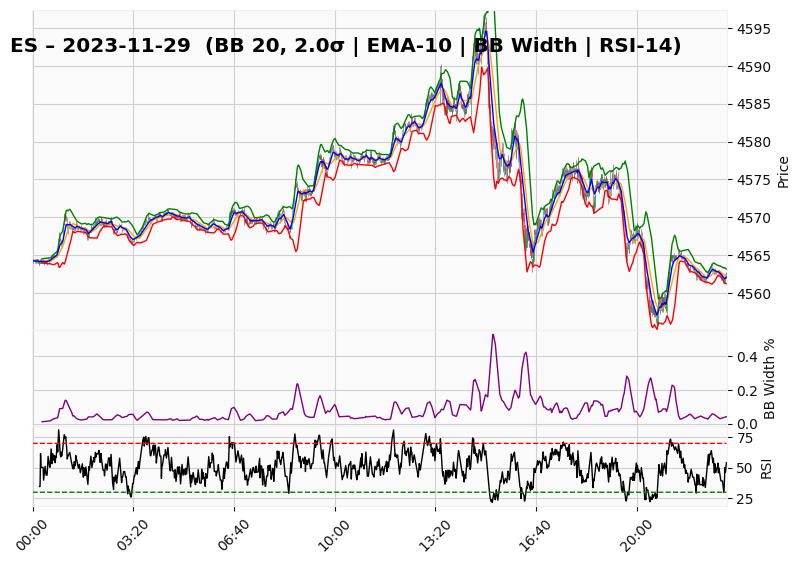

{'n_trades': 2, 'total_pnl': -487.5, 'max_dd': -487.5, 'mar_ratio': -1.0, 'win_rate': 0.0, 'avg_R': 0.0}


,dateMarker,entry_time,exit_time,side,entry_px,exit_px,stop_px,target_px,risk_points,reward_points,...,entry_vol_ratio,entry_ADX14,entry_ADX60,entry_DIp60,entry_DIn60,entry_DIp14,entry_DIn14,entry_ADX14_rise,entry_ATR5,entry_ATR60
0,2023-11-29,15:16:00,16:17:00,long,4580.25,4567.5,4567.6875,4597.00,12.5625,16.75,...,1.496050,39.628884,11.239104,17.385005,28.38124,8.471181,34.987981,9.130339,2.438035,1.629648
1,2023-11-29,16:20:00,20:24:00,long,4568.75,4559.0,4559.3750,4581.25,9.3750,12.50,...,1.212214,38.996394,18.309702,16.596771,30.73937,13.957432,37.474224,6.785416,2.206054,1.819855


In [110]:

date_str = '2023-11-29'
day = pd.to_datetime(date_str).date()
ES_Data = regime_df[regime_df['Date'] == day].copy()


plot_es_bollinger_day(ES_Data, date_str, length=20, mult=2.0, rsi_len=14,
                      # t_start="12:00",t_end="15:00")
                      )






trades_bb_mr, stats_bb_mr = backtest_bb_mean_revert_es2(
    ES_Data,
    width_pct_min=0.60,
    width_drop_min=0.05,
    length=20,
    mult=2.0,
    R_mult=2.0,
    buffer_points=3.0,
    tick_size=0.25,
    slippage_points=0.25,
    point_value=50.0,
    session_start="09:30:00",
    session_end="16:00:00",
    rsi_len= 14
)




print(stats_bb_mr)

trades_bb_mr

In [99]:
regime_df_testingSet = regime_df[:int(len(regime_df)/2)]
dates = regime_df_testingSet['Date'].unique()
dates

totalTrades = None

for date in dates:
    day = pd.to_datetime(date).date()
    ES_Data = regime_df_testingSet[regime_df_testingSet['Date'] == day].copy()
    
    trades_bb_mr, stats_bb_mr = backtest_bb_mean_revert_es2(
        ES_Data,
        width_pct_min=0.60,
        width_drop_min=0.05,
        length=20,
        mult=2.0,
        R_mult=2.0,
        buffer_points=3.0,
        tick_size=0.25,
        slippage_points=0.25,
        point_value=50.0,
        session_start="09:30:00",
        session_end="16:00:00",
        rsi_len= 14
    )
    
    if totalTrades is None:
        totalTrades = trades_bb_mr.copy()
    else:
        totalTrades = pd.concat([totalTrades, trades_bb_mr])

totalTrades["profitableTrade"] = (totalTrades["pnl_points"] > 0).astype(int)
totalTrades

,dateMarker,entry_time,exit_time,side,entry_px,exit_px,stop_px,target_px,risk_points,reward_points,...,entry_ADX14,entry_ADX60,entry_DIp60,entry_DIn60,entry_DIp14,entry_DIn14,entry_ADX14_rise,entry_ATR5,entry_ATR60,profitableTrade
0,2023-11-10,09:14:00,10:33:00,long,4363.00,4358.50,4358.6875,4368.75,4.3125,5.75,...,45.599229,17.558253,16.088691,27.786088,7.737877,38.065094,2.640655,1.153360,0.846820,0
1,2023-11-10,13:10:00,13:44:00,short,4374.75,4379.00,4378.6875,4369.50,3.9375,5.25,...,25.979183,18.371377,29.944394,16.318983,36.828339,13.414658,-2.504269,1.552893,1.024142,0
2,2023-11-10,16:15:00,17:33:00,short,4391.00,4403.75,4403.5625,4374.25,12.5625,16.75,...,45.381206,12.676481,26.678240,16.101857,37.969604,8.674110,5.994188,1.811868,2.263995,0
3,2023-11-10,17:33:00,17:35:00,short,4402.75,4408.25,4408.0000,4395.75,5.2500,7.00,...,34.050079,20.538528,26.530844,13.032648,34.235687,7.190451,1.752638,1.932851,1.723653,0
4,2023-11-10,17:55:00,18:40:00,short,4414.00,4420.50,4420.1875,4405.75,6.1875,8.25,...,46.999578,26.150514,31.469665,12.950134,43.503101,11.507277,-1.930875,1.748995,1.714556,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,2024-11-14,13:32:00,14:40:00,long,6014.75,6007.00,6007.2500,6024.75,7.5000,10.00,...,21.565450,5.671772,18.573456,31.016415,11.118375,44.489436,5.655101,3.129908,1.138452,0
1,2024-11-14,14:46:00,17:16:00,long,6002.75,5989.25,5989.4375,6020.50,13.3125,17.75,...,29.440241,10.200195,17.916632,26.958519,13.307685,30.940889,7.203719,3.697235,2.056577,0
2,2024-11-14,20:13:00,21:09:00,long,5980.50,5965.25,5965.5000,6000.50,15.0000,20.00,...,36.751142,11.673181,19.923421,27.159486,20.671730,30.755174,-0.016631,4.726621,2.639514,0
0,2024-11-15,15:07:00,15:22:00,long,5922.50,5908.75,5909.0000,5940.50,13.5000,18.00,...,28.428916,16.610118,16.287369,24.354619,15.298711,24.566603,4.038458,3.746440,2.516310,0


In [108]:
tt = totalTrades.copy()

# tt = tt[tt['side'] == 'long']
# tt = tt[tt['entry_ADX60'] >20]
# 
tt = tt[tt['entry_DIp60'] <tt['entry_DIn60']]
tt = tt[tt['side'] == 'long']

print(len(tt[tt['pnl_points']>0]) / (len(tt[tt['pnl_points']>0]) + len(tt[tt['pnl_points']<0])))
print(tt['pnl_points'].sum())
tt

0.42857142857142855
-237.5


,dateMarker,entry_time,exit_time,side,entry_px,exit_px,stop_px,target_px,risk_points,reward_points,...,entry_ADX14,entry_ADX60,entry_DIp60,entry_DIn60,entry_DIp14,entry_DIn14,entry_ADX14_rise,entry_ATR5,entry_ATR60,profitableTrade
0,2023-11-10,09:14:00,10:33:00,long,4363.00,4358.50,4358.6875,4368.75,4.3125,5.75,...,45.599229,17.558253,16.088691,27.786088,7.737877,38.065094,2.640655,1.153360,0.846820,0
0,2023-11-15,13:47:00,23:57:00,long,4520.75,4516.25,4505.3750,4541.25,15.3750,20.50,...,15.973270,11.968874,21.317667,24.443554,15.598323,29.598711,4.059844,2.046076,1.489309,0
1,2023-11-17,13:41:00,13:55:00,long,4534.25,4530.00,4530.3125,4539.50,3.9375,5.25,...,29.002208,11.863745,19.239955,22.262168,10.611052,33.280580,0.473847,1.631232,0.953454,0
2,2023-11-17,14:42:00,19:02:00,long,4515.25,4531.25,4503.0625,4531.50,12.1875,16.25,...,58.791343,20.527766,9.857679,30.901795,3.852977,36.439420,8.270781,2.547060,1.453614,1
1,2023-11-20,20:51:00,21:06:00,long,4563.50,4558.50,4558.8125,4569.75,4.6875,6.25,...,21.775364,25.226932,21.096143,22.344215,10.274907,38.868570,7.028926,1.562143,1.152309,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1,2024-11-11,18:01:00,18:21:00,long,6022.75,6015.50,6015.8125,6032.00,6.9375,9.25,...,24.958760,12.680426,14.382823,25.016392,11.471063,38.972379,2.253325,1.807416,1.578158,0
0,2024-11-14,13:32:00,14:40:00,long,6014.75,6007.00,6007.2500,6024.75,7.5000,10.00,...,21.565450,5.671772,18.573456,31.016415,11.118375,44.489436,5.655101,3.129908,1.138452,0
1,2024-11-14,14:46:00,17:16:00,long,6002.75,5989.25,5989.4375,6020.50,13.3125,17.75,...,29.440241,10.200195,17.916632,26.958519,13.307685,30.940889,7.203719,3.697235,2.056577,0
2,2024-11-14,20:13:00,21:09:00,long,5980.50,5965.25,5965.5000,6000.50,15.0000,20.00,...,36.751142,11.673181,19.923421,27.159486,20.671730,30.755174,-0.016631,4.726621,2.639514,0


In [49]:
totalTrades["entry_datetime"] = pd.to_datetime(
    totalTrades["dateMarker"].astype(str) + " " + totalTrades["exit_time"].astype(str),
    errors="coerce"
)



totalTrades["time_bucket_30m"] = (
    totalTrades["entry_datetime"]
    .dt.floor("30min")
    .dt.strftime("%H:%M")
)

totalTrades

bucket_stats = (
    totalTrades
    .groupby("time_bucket_30m")
    .agg(
        n_trades=("pnl_points", "count"),
        win_rate=("profitableTrade", "mean"),
        avg_pnl=("pnl_points", "mean"),
        median_pnl=("pnl_points", "median"),
        total_pnl=("pnl_points", "sum")
    )
    .sort_index()
)
bucket_stats

,n_trades,win_rate,avg_pnl,median_pnl,total_pnl
time_bucket_30m,,,,,
00:30,2,0.500000,0.125000,0.125,0.25
01:00,6,0.333333,-3.125000,-5.750,-18.75
01:30,5,0.400000,2.050000,-5.000,10.25
02:00,5,0.000000,-11.100000,-10.250,-55.50
02:30,3,0.666667,3.416667,7.000,10.25
03:00,1,0.000000,-5.000000,-5.000,-5.00
03:30,6,0.500000,1.125000,0.000,6.75
04:00,2,0.500000,1.500000,1.500,3.00
04:30,4,0.500000,0.000000,-0.250,0.00


In [82]:
from datetime import time
filtered_trades = totalTrades[(totalTrades["entry_time"] >= time(13, 30)) & (totalTrades["entry_time"] <= time(15, 0))]
filtered_trades.to_csv('test111.csv')